# Libraries

In [146]:
# Libraries
import numpy as np
import random
from numpy.random import default_rng
import matplotlib.pyplot as plt
from ete3 import *
#from ete3 import Tree, TreeNode, TreeStyle, NodeStyle, TextFace
import PyQt5
from decimal import Decimal, getcontext
rng = default_rng()
from PIL import Image
import math

# Simulation Algorithms

In [147]:
# Algorithms
def StemBuilder(stem_population_size, stem_rate):
    # An ancestry list to containt cell relations
    stem_ancestry = list(np.zeros(2*stem_population_size-1))
    stem_ancestry[0] = (0, 0, "origin")
    # The initial population:
    stem_population = [0]
    time = 0
    next_id = 1
    while len(stem_population) != stem_population_size:
        # Calculating the rate parameter and the exact time when the event takes place
        rate_parameter = len(stem_population)*stem_rate
        time += np.random.exponential(scale=1/rate_parameter)
        # Sampling the population
        cell  = random.sample(range(0, len(stem_population)), 1)[0]
        # Running the event
        stem_ancestry[next_id] = (stem_population[cell], time, "stem")
        stem_population[cell] = next_id
        next_id += 1
        stem_ancestry[next_id] = (stem_population[cell], time, "stem")
        stem_population.append(next_id)
        next_id += 1
    
    return stem_population, stem_ancestry, time, next_id

def DiffBuilder(diff_population_size, diff_rate, stem_population, stem_ancestry, current_time, id, stem_rate):
    # An ancestry list to contain cell relations
    diff_ancestry = list(np.zeros(2*diff_population_size))
    original_ancestry = stem_ancestry + diff_ancestry
    
    time = current_time
    next_id = id
    # populattions:
    current_stem_population = stem_population
    diff_population = []
    # rate parameter
    rate_parameter = len(stem_population)*stem_rate
    
    while len(diff_population) != diff_population_size:
        time += np.random.exponential(scale=1/rate_parameter)
        # Events in the stem cell population
        stemcell1, stemcell2 = random.sample(range(0, len(current_stem_population)), 2)
        original_ancestry[next_id] = (current_stem_population[stemcell1], time, "Stem")
        current_stem_population[stemcell2] = next_id
        next_id += 1
        original_ancestry[next_id] = (current_stem_population[stemcell1], time, "Stem")
        current_stem_population[stemcell1] = next_id
        next_id += 1
        # Events in the diff cell population
        original_ancestry[next_id] = (current_stem_population[stemcell2], time, "Stem")
        diff_population.append(next_id)
        next_id += 1
        original_ancestry[next_id] = (current_stem_population[stemcell2], time, "Stem")
        diff_population.append(next_id)
        next_id += 1
    
    return original_ancestry, current_stem_population, diff_population, next_id

def EventDecider(p0):
    # Generating a random number between 0 and 1
    random_number = random.uniform(0,1)
    event = "string"
    # Deciding which evenet happens:
    if random_number < p0:
        event = "Stem"
    else:
        event = "Diff"
    return event

def DataTrimmer(ancestry):
    # Removing unwanted data
    data = []
    for event in ancestry:
        if type(event) == tuple:
            data.append(event)
    return data

def Simulation(stem_population_size, stem_rate, diff_population_size, diff_rate):

    # Consturcting the Sten cell population
    temp_stem, temp_anc, current_time, id = StemBuilder(stem_population_size, stem_rate)
    
    # Constructing the Diff cell population
    original_ancestry, stem_population, diff_population, id = DiffBuilder(diff_population_size, diff_rate, temp_stem, temp_anc, current_time, id, stem_rate)
    
    population_size = stem_population_size + diff_population_size
    # The number of generations that will be created 
    iterations = population_size*population_size*10

    # Creating the two distinct populations
    #stem_population = np.zeros(stem_population_size, dtype=int)
    #diff_population = np.zeros(diff_population_size, dtype=int)

    # Rate of which either event happens and the mean time between events
    R = stem_population_size*stem_rate + diff_population_size*diff_rate
    scale_parameter = 1/R
    
    # The chance that the event of the stem cell population happens
    p0 = (stem_population_size*stem_rate)/R
    # The chance that the event of the diff cell population happens
    p1 = (diff_population_size*diff_rate)/R

    # An array to keep track of ancestry
    ancestry_cells = original_ancestry + list(np.zeros(4*iterations+1))
    #ancestry_cells[0] = (0, 0, "origin")
    #ancestry_times = np.zeros(4*iterations+1)

    # Running the simulation:
    time = 0
    next_id = id

    for iteration in range(iterations):
        # Time of the event
        time += np.random.exponential(scale=scale_parameter)
        # deciding which event happens
        event = EventDecider(p0)
        # deciding which 2 diff cells partake in the event
        diff_cell1, diff_cell2 = random.sample(range(0, diff_population_size), 2)
        # Running the events:
        if event == "Stem":
            # Events in the stem cell population
            stemcell1, stemcell2 = random.sample(range(0, stem_population_size), 2)
            ancestry_cells[next_id] = (stem_population[stemcell1], time, event)
            stem_population[stemcell2] = next_id
            next_id += 1
            ancestry_cells[next_id] = (stem_population[stemcell1], time, event)
            stem_population[stemcell1] = next_id
            next_id += 1
            # Events in the diff cell population
            ancestry_cells[next_id] = (stem_population[stemcell2],time, event)
            diff_population[diff_cell2] = next_id
            next_id += 1
            ancestry_cells[next_id] = (stem_population[stemcell2], time, event)
            diff_population[diff_cell1] = next_id
            next_id += 1
        else:
            ancestry_cells[next_id] = (diff_population[diff_cell1], time, event)
            diff_population[diff_cell2] = next_id
            next_id += 1
            ancestry_cells[next_id] = (diff_population[diff_cell1], time, event)
            diff_population[diff_cell1] = next_id
            next_id += 1
    
    ancestry = DataTrimmer(ancestry_cells)
    
    return list(stem_population), list(diff_population), ancestry

def DataSeparator(ancestry):
    # Separating the data
    ancestry_cells = []
    ancestry_times = []
    ancestry_types = []
    for event in ancestry:
        ancestry_cells.append(event[0])
        ancestry_times.append(event[1])
        ancestry_types.append(event[2])

    return ancestry_cells, ancestry_times, ancestry_types

def TreeMaker(stem_population, diff_population, time_ancestry, ancestry, sample_size = 0):
        
    # Connecting the differentiated cell population and stem cell population
    present_population = stem_population + diff_population
    population_size = len(present_population)


    present_time = max(time_ancestry)
    
    # Sampleing the population in a list
    if sample_size == 0:
        population_sample = present_population
        sample_size = len(population_sample)
    else:
        population_sample=random.sample(present_population, sample_size)

    original_sample = population_sample.copy()

    # Identifying the types of cells within the sample
    sample_types = []
    for sample in population_sample:
        if sample in stem_population:
            sample_types.append("stem")
        else:
            sample_types.append("Diff")


    # Identifying the original node:
    youngest = max(population_sample)
    while youngest > len(present_population):
        father  = ancestry[youngest]
        youngest = father

    # Names of the sampled individuals
    strings = [repr(i) for i in population_sample]
    # Ages of the sampled individuals
    ages = [present_time]*sample_size
    # Creating the tree using the newick format
    while len(population_sample)>1:
        # Chosing the youngest individual within the sampled population
        youngest = max(population_sample)
        index = population_sample.index(youngest)
        # Determining the father of the youngest
        father  = ancestry[youngest]
        # Chaning the youngest to its father
        population_sample[index] = father
        # Searching the sample for individuals with the same father
        indicies = [index for index,value in enumerate(population_sample) if value == father] 
        # Should the sample have individuals with the same father tha newick string is formed 
        # and the individuals removed from the sample
        if len(indicies) > 1:
            fathers_age = time_ancestry[youngest]  #ids give the age of a node as: age = next_id // 2, e.g. 31//2==30//2==15
            smaller_index, larger_index = sorted(indicies)       
            strings[smaller_index] = \
                "("+strings[smaller_index]+":"+repr(ages[smaller_index]-fathers_age)\
            +","+strings[larger_index]+":"+repr(ages[larger_index]-fathers_age) + ")"
            ages[smaller_index]= fathers_age
            population_sample.pop(larger_index)
            strings.pop(larger_index)
            ages.pop(larger_index)      

    newick_string = strings[0]+";"

    return newick_string, original_sample, sample_types

def CoalescentTimeCalculator(tree = object):
    # Getting the leaves of the tree
    leaves = tree.get_leaves()
    # A list that will hold the coalescent times
    coalescent_times = []
    # cycling through the leaves and getting all their ancesotrs. Than cycling through their ancestors and calulaiing the distance between ancestor and leaf
    # if the distance is not in coalescent_time than we append it
    ancestors_list = []
    for leaf in leaves:
        ancestors = leaf.get_ancestors()
        for ancestor in ancestors:
            time = ancestor.get_distance(leaf)
            ancestor.add_features(coalescent_time = time)
            if ancestor not in ancestors_list:
                coalescent_times.append(time)
                ancestors_list.append(ancestor)
    coalescent_times.sort()
    
    
    return coalescent_times

# Tree Displaying Algorithms

In [148]:
# Indentifying which coalescent event was which type:
def CoalescentType(ancestry_times, ancestry_types, coalescent_times):
    
    diff_coalesence = []
    stem_coalesence = []
    
    for coalescence in coalescent_times:
        time = max(ancestry_times)-coalescence 
        for index, _t in enumerate(ancestry_times):
            if math.isclose(_t, time):
                break
        if ancestry_types[index] == "Diff":
            diff_coalesence.append(coalescence)
        else:
            stem_coalesence.append(coalescence)
        
    return diff_coalesence, stem_coalesence

# Rendering the coalescent tree
def TreeDisplay(tree = object, stem_coalesence = list, sampled_population = list, sampled_types = list, name = int, stem_size = int, diff_size = int, stem_rate = int, diff_rate = int):
    # Creating the tree style for display
    # The Basic Tree style:
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.show_branch_length = False
    ts.branch_vertical_margin = 4
    ts.show_branch_support = False
    ts.draw_guiding_lines = False
    ts.aligned_header = False
    ts.legend = False
    ts.show_scale = False
    ts.margin_bottom = 5
    ts.margin_top = 5
    ts.show_border = True
    ts.margin_left = 5
    ts.margin_right = 5
    ts.rotation = 90
    ts.title.add_face(faces.TextFace(f"Stem_pop = {stem_size}, Diff_pop = {diff_size}, Stem_rate = {stem_rate}, diff_rate = {diff_rate}", fsize=4), 0)

    # The differentiated ancestor node style:
    diff_anc_style = NodeStyle()
    diff_anc_style["shape"] = "sphere"
    diff_anc_style["size"] = 0
    diff_anc_style["fgcolor"] = "#0000aa"
    diff_anc_style["vt_line_width"] = 1
    diff_anc_style["hz_line_width"] = 1
    diff_anc_style["vt_line_color"] = "#0000aa"
    diff_anc_style["hz_line_color"] = "#0000aa"

    # The stem ancestor node style:
    stem_anc_style = NodeStyle()
    stem_anc_style["shape"] = "sphere"
    stem_anc_style["size"] = 0
    stem_anc_style["fgcolor"] = "red"
    stem_anc_style["vt_line_width"] = 1
    stem_anc_style["hz_line_width"] = 1
    stem_anc_style["vt_line_color"] = "#ff0000"
    stem_anc_style["hz_line_color"] = "#ff0000"

    # The differentiated cells node type:
    diff_nstyle = NodeStyle()
    diff_nstyle["shape"] = "sphere"
    diff_nstyle["size"] = 2
    diff_nstyle["fgcolor"] = "blue"
    diff_nstyle["vt_line_width"] = 1
    diff_nstyle["hz_line_width"] = 1
    diff_nstyle["vt_line_color"] = "#0000aa"
    diff_nstyle["hz_line_color"] = "#0000aa"

    # The Stem cell node type
    stem_nstyle = NodeStyle()
    stem_nstyle["shape"] = "sphere"
    stem_nstyle["size"] = 2
    stem_nstyle["fgcolor"] = "red"
    stem_nstyle["vt_line_width"] = 1
    stem_nstyle["hz_line_width"] = 1
    stem_nstyle["vt_line_color"] = "#ff0000"
    stem_nstyle["hz_line_color"] = "#ff0000"
    
    
    
    # Giving every node a new attribute to distinguish between types of coalesence
    for n in tree.traverse():
        n.add_features(celltype = "undecided")
    
    # Assigning the ancestor nodes the correct celltype
    leaves = tree.get_leaves()
    for leaf in leaves:
            ancestors = leaf.get_ancestors()
            for ancestor in ancestors:
                time = ancestor.get_distance(leaf)
                if time in stem_coalesence:
                    ancestor.celltype = "Stem_ancestor"
                else:
                    ancestor.celltype = "Diff_ancestor"

    leaves[0].get_ancestors()[-1].celltype = "Stem_ancestor"
    
    # Assigning the ancestors the correct style
    for n in tree.traverse():
        if n.celltype == "Stem_ancestor":
            n.set_style(stem_anc_style)
        if n.celltype == "Diff_ancestor":
            n.set_style(diff_anc_style)
        else:
            pass

    # Assigning the correct celltype and style for the leaves:
    for sample_index, sample_name in enumerate(sampled_population):
        type_of_sample = sampled_types[sample_index]
        node = tree.get_leaves_by_name(str(sample_name))[0]
        if type_of_sample == "Diff":
            node.set_style(diff_nstyle)
            node.celltype = "Diff"
        else:
            node.set_style(stem_nstyle)
            node.celltype = "Stem"
    
    tree.render(f"Tree{name}.png", units="px",w = 3000, tree_style=ts)

    return tree

# Coalesence Analyzer Algorthms

In [149]:
def Coalescentparameter(coalescent_times, tree):
    # Calculating how many stem cell and diff cell are in the sample
    stem_count = len(tree.search_nodes(celltype = "Stem"))
    diff_count = len(tree.search_nodes(celltype = "Diff"))
    
    coalescence = coalescent_times.copy()
    # Creating the r parameter for the whole coalesence:
    coalesence_r = list(np.arange(1, len(coalescence)+1))
    coalesence_r.reverse()
    coalescence.insert(0, 0)
    coalesence_r.insert(0, diff_count+stem_count)

    return coalesence_r, coalescence

def DifferentiatedCoalescenceTimes(tree, coalescent_times):

    # Calculating how many stem cell and diff cell are in the sample
    stem_count = len(tree.search_nodes(celltype = "Stem"))
    diff_count = len(tree.search_nodes(celltype = "Diff"))
    
    # Puting all ancestors into a list:
    ancestors = tree.search_nodes(celltype = "Stem_ancestor") + tree.search_nodes(celltype = "Diff_ancestor")
    
    # Gathering those coalescent times when the number of differentiated cells were reduced in the sample
    # This are the ancestors who have at least one children who is either a diff cell or diff ancestor
    diff_reduction_times = []
    for ancestor in ancestors:
        children = ancestor.get_children()
        for child in children:
            if child.celltype == "Diff_ancestor" or child.celltype == "Diff":
                diff_reduction_times.append(ancestor.coalescent_time)
                break
    
    diff_reduction_times.sort()
    
    # The number of diff cell at given time:
    diff_r = list(np.arange(0, len(diff_reduction_times)))
    diff_r.reverse() # To match with the times
    diff_reduction_times.insert(0,0) # Adding the present time
    diff_r.insert(0, diff_count)
    #diff_r.insert(0, diff_count)

    # Adding zero to the last coalescent time incase differentiated cell all coalesced into stem cells before that
    if diff_reduction_times[-1] < coalescent_times[-1]:
        diff_reduction_times.append(coalescent_times[-1])
        diff_r.append(0)

    return diff_r, diff_reduction_times

def StemCoalesenceTimes(diff_reduction_times, coalesence_r, coalescence, diff_r):
    # Calculating the change in stem cell numbers 
    stem_r = []
    index = 0
    for col_index, time in enumerate(coalescence):
        current_diff_time = diff_reduction_times[index]
        if time <= current_diff_time:
            stem_r.append(coalesence_r[col_index]-diff_r[index])
        if time > current_diff_time:
            stem_r.append(coalesence_r[col_index]-diff_r[index+1])
            index += 1
    return stem_r

# Style used for the display of the Coalescent tree

# Parameters

In [150]:
stem_size = [10, 100, 200, 250]
diff_size = [490, 400, 300, 250]
stem_rate = 1
diff_rate = [100, 50, 20, 10]

# Simulations

In [151]:
# A function that runs the simulation and tree dis
def Simulaton2(stem_size, diff_size, stem_rate, diff_rate, name):
    
    stem_population, diff_population, ancestry = Simulation(stem_size, stem_rate, diff_size, diff_rate)
    ancestry_cells, ancestry_times, ancestry_types = DataSeparator(ancestry)
    newick_string, sampled_population, sampled_types = TreeMaker(stem_population, diff_population, ancestry_times, ancestry_cells, sample_size = 100)
    tree = Tree(newick_string)
    coalescent_times = CoalescentTimeCalculator(tree)
    diff_coalesence, stem_coalesence = CoalescentType(ancestry_times, ancestry_types, coalescent_times)
    tree = TreeDisplay(tree, stem_coalesence, sampled_population, sampled_types, name, stem_size, diff_size, stem_rate, diff_rate,)
    
    return tree, coalescent_times

In [152]:
tree2, coalescent_times2 = Simulaton2(10, 390, 1, 100, 2)
tree3, coalescent_times3 = Simulaton2(50, 350, 1, 50, 3)
tree4, coalescent_times4 = Simulaton2(10, 390, 1, 50, 4)

In [248]:
# Test Simulation
test_stem_size = 50
test_diff_size = 350
test_diff_rate = 100
tree, coalescent_times = Simulaton2(test_stem_size, test_diff_size, 1, test_diff_rate, 1)

# Analyzing Coalescent

In [249]:
coalesence_r1, coalescence1 = Coalescentparameter(coalescent_times, tree)
diff_r1, diff_times1 = DifferentiatedCoalescenceTimes(tree, coalescence1)
stem_r1 = StemCoalesenceTimes(diff_times1, coalesence_r1, coalescence1, diff_r1)
print(max(stem_r1))

13


In [250]:
def r(time, N, sample):
    nominator = N*(N-1)*sample
    denominator = time*sample+N*(N-1)
    return nominator/denominator

In [251]:
def l2(t,N):
    return 1/(N**2/2 - N**2/t)

In [252]:
def func(r_min, N, r_max):
    return N*(N-1)*(1/(r_min) - (1/r_max))
number = np.linspace(2, 82, 1000)

In [259]:
def r2(T, N, sample, delta):
    nominator = 2*(N-1)*delta*sample
    denominator = T*sample+2*(N-1)*delta

    return nominator/denominator

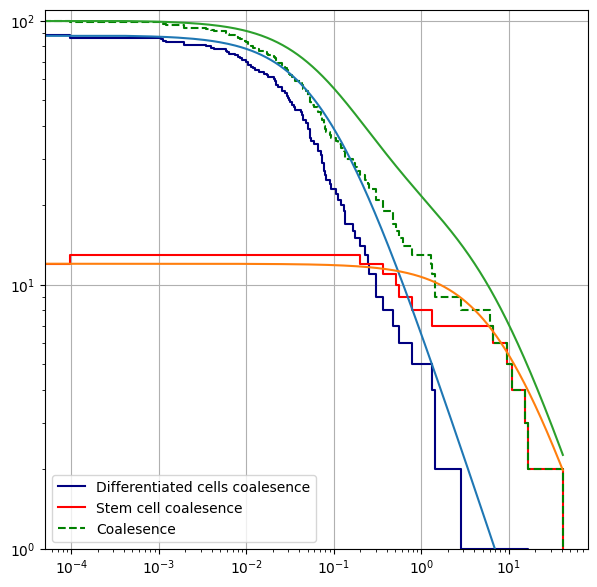

In [260]:
# plotting the coalescent times:
times = np.linspace(0,coalescent_times[-1],100000)
plt.figure(figsize=(7,7))
plt.step(diff_times1, diff_r1, where="post", ls = "-", color = "navy", label = "Differentiated cells coalesence")
plt.step(coalescence1, stem_r1, where="post", ls = "-", color = "red", label = "Stem cell coalesence")
plt.step(coalescence1, coalesence_r1, where="post", ls = "--", color = "green", label = "Coalesence")
#plt.xlim(0,0.05)
plt.yscale("log")
#plt.yticks([1, 10])
plt.xscale("log")
t = np.linspace(0, 1, 1000000)
def l(t, N):
    return N/(t+1)
plt.plot(times, r2(times, test_diff_size, diff_r1[0], 1/test_diff_rate))
plt.plot(times, r2(times, test_stem_size, stem_r1[0], 1))
plt.plot(times, r2(times, 350, 82, 1/100) + r2(times, 50, 18, 1))
#plt.plot(t, l(t*200, 180))
#plt.plot(t, l(t*50, 20))
plt.ylim(1, 110)
plt.legend()
plt.grid()

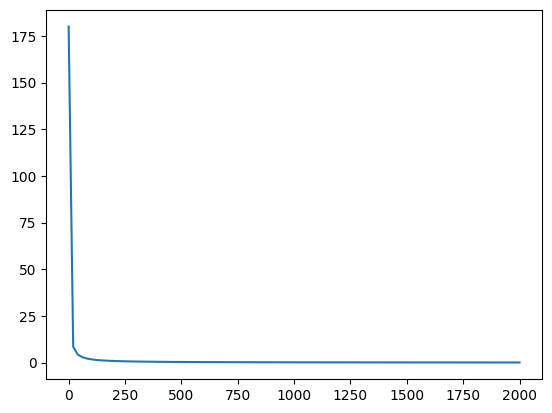

In [156]:
t = np.linspace(0, 2000, 100)
def l(t, N):
    return N/(t+1)
plt.plot(t, l(t, 180))